Checking volume-84.nii ...
✅ File found and non-empty: 384.3 MB
Checking segmentation-84.nii ...
✅ File found and non-empty: 192.15 MB
Image shape: (512, 512, 733)
Mask shape: (512, 512, 733)


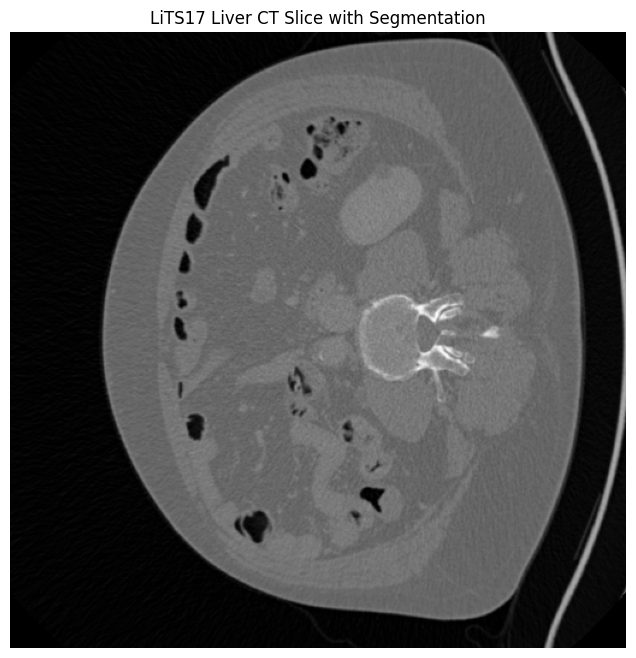

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ Update this path to your new local folder
data_dir = r"C:\Users\sohel\Downloads\Ai_health\LiTS17"

vol_path = os.path.join(data_dir, "volume-84.nii", "volume-84.nii")
seg_path = os.path.join(data_dir, "segmentation-84.nii", "segmentation-84.nii")

# Load and validate
for path in [vol_path, seg_path]:
    print(f"Checking {os.path.basename(path)} ...")
    if not os.path.exists(path):
        print("❌ File not found:", path)
    elif os.path.getsize(path) < 1000000:
        print("⚠️ File too small:", os.path.getsize(path), "bytes")
    else:
        print("✅ File found and non-empty:", round(os.path.getsize(path)/1e6, 2), "MB")

# Load using nibabel
img = nib.load(vol_path)
mask = nib.load(seg_path)

img_data = img.get_fdata()
mask_data = mask.get_fdata()

print("Image shape:", img_data.shape)
print("Mask shape:", mask_data.shape)

# Show a mid-slice overlay
mid = img_data.shape[2] // 2
plt.figure(figsize=(8, 8))
plt.imshow(img_data[:, :, mid], cmap="gray")
plt.imshow(np.ma.masked_where(mask_data[:, :, mid] == 0, mask_data[:, :, mid]), alpha=0.4, cmap="jet")
plt.title("LiTS17 Liver CT Slice with Segmentation")
plt.axis("off")
plt.show()


In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Use a subset of slices for demo (e.g., 100 random slices)
n_slices = img_data.shape[2]
slices = np.arange(n_slices)
train_idx, val_idx = train_test_split(slices, test_size=0.2, random_state=42)

print(f"Train slices: {len(train_idx)}, Validation slices: {len(val_idx)}")


Train slices: 586, Validation slices: 147


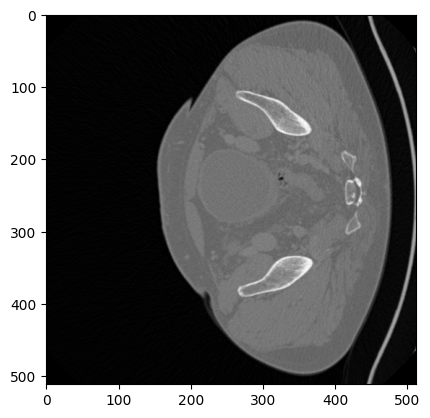

In [3]:
X = img_data / np.max(img_data)
y = (mask_data > 0).astype(np.uint8)

# Example slice for sanity check
plt.imshow(X[:, :, 200], cmap="gray")
plt.imshow(np.ma.masked_where(y[:, :, 200]==0, y[:, :, 200]), alpha=0.4)
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape=(512, 512, 1)):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 256, 256,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 512, 512,  │          0 │ conv2d_6[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512, 512,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 512, 512,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 512, 512,  │         17 │ conv2d_7[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,417 (415.69 KB)

 Trainable params: 106,417 (415.69 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import numpy as np

# Normalize image
X_norm = (img_data / np.max(img_data)).astype(np.float32)
y_mask = (mask_data > 0).astype(np.uint8)

# Select 100 slices for training
slices = np.arange(100, 200)  # adjust as needed

# Correct reshaping: move slices to first dimension
X_train = np.transpose(X_norm[:, :, slices], (2, 0, 1))  # (num_slices, 512, 512)
y_train = np.transpose(y_mask[:, :, slices], (2, 0, 1))

# Add channel dimension
X_train = np.expand_dims(X_train, axis=-1)  # (num_slices, 512, 512, 1)
y_train = np.expand_dims(y_train, axis=-1)  # (num_slices, 512, 512, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (100, 512, 512, 1)
y_train shape: (100, 512, 512, 1)


In [11]:
# Clear the TF graph
import tensorflow as tf
tf.keras.backend.clear_session()

# Rebuild and compile again
model = build_unet(input_shape=(512, 512, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train cleanly
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=2,
    validation_split=0.1
)



Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9803 - loss: 0.0920 - val_accuracy: 1.0000 - val_loss: 5.5326e-36
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.3838e-37 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [12]:
import numpy as np

ratio = np.sum(y_train) / np.prod(y_train.shape)
print("Liver pixels ratio:", ratio)


Liver pixels ratio: 0.0


In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1
)


In [16]:
slices = np.random.choice(np.arange(img_data.shape[2]), 200, replace=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


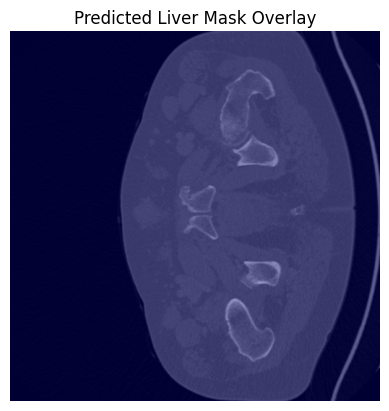

In [17]:
pred = model.predict(X_train[:1])
plt.imshow(X_train[0,:,:,0], cmap="gray")
plt.imshow(pred[0,:,:,0] > 0.5, alpha=0.4, cmap="jet")
plt.title("Predicted Liver Mask Overlay")
plt.axis("off")
plt.show()


In [10]:
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=2,
    validation_split=0.1
)


Epoch 1/5


ValueError: Creating variables on a non-first call to a function decorated with tf.function.